# K-means Clustering for Image Compression

## Introduction
 
Image compression through K-means clustering offers an elegant solution to reducing image file sizes while maintaining visual quality. This technique leverages the observation that most images don't utilize the full spectrum of available colors effectively. By treating each pixel's RGB values as a point in three-dimensional space, we can use K-means clustering to identify a smaller set of representative colors that capture the essence of the image while significantly reducing its color palette.

## Technical Background
 
The RGB color space represents each pixel using three values for red, green, and blue intensities, each ranging from 0 to 255. This creates a vast color space capable of representing over 16.7 million unique colors. However, most natural images use only a fraction of these colors, and many neighboring colors are so similar that the human eye can barely distinguish between them. This redundancy in color space provides an opportunity for compression.
 
K-means clustering takes advantage of this redundancy by finding groups of similar colors and replacing them with a single representative color. The algorithm identifies K centroids in the RGB color space, where each centroid represents the average color of all pixels assigned to its cluster. By carefully choosing these representative colors, we can maintain visual quality while drastically reducing the number of unique colors in the image.

## Import Libraries

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from skimage import io, img_as_float
sn.set_theme(style='ticks') # set the default seaborn theme for prettier plots

## Loading and Preparing the Image
 
The first critical decision in our implementation involves converting the image data to an appropriate format for processing. We convert the image to float32 format instead of working with integer values between 0-255. This decision stems from the need for numerical stability during the clustering process. Integer arithmetic can lead to rounding errors and potential overflow issues during centroid calculations, whereas floating-point numbers provide the precision needed for accurate color averaging and distance calculations.

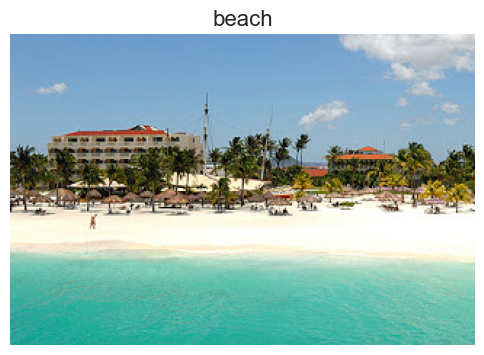

In [28]:
I = io.imread('beach.bmp')
I = img_as_float(I)
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(I)
ax.set_title('beach', fontsize=16)
ax.axis('off')
plt.show()

The image is stored as a 3D numpy array, where:
- I[i,j,k]: i is row index, j is column index, and k is channel (color) index
- I[0,0] is the pixel at row-0 and col-0, and it has three values r,g,b
 
Let's examine the shape of our image:

In [29]:
I.shape

(214, 320, 3)

In [30]:
# Look at the RGB values of a SINGLE pixel
I[0,0]

array([0.43137255, 0.60392157, 0.78823529])

## Preparing Image For K-means
 
For K-means clustering, we need to reshape our image data so that:
- Each row represents one data point (a pixel with RGB values)
- We have a 2D matrix with shape (number_of_pixels, 3)
- The data type is float32 for numerical stability
 
The reshaping operation transforms our image from a three-dimensional array (height × width × RGB) into a two-dimensional array where each row represents a pixel's RGB values. This transformation is necessary because K-means expects input data where each row is a single data point and each column is a feature.

In [31]:
X = I.reshape(-1, 3).astype(np.float32)
X.dtype

dtype('float32')

## Applying K-means Clustering
 
We'll use scikit-learn's KMeans implementation, which defaults to the k-means++ initialization strategy. This choice significantly improves the quality of our results compared to random initialization, as k-means++ selects initial centroids that are well-distributed among the data points. This reduces the likelihood of poor local optima and generally leads to better color selection.
 
The number of clusters K directly determines our compression level. Through extensive testing, values between 5 and 32 provide the most interesting results:
 - K=5 creates a dramatic posterized effect (artistic but may lose detail)
 - K=32 typically preserves enough detail while still providing compression

In [32]:
from sklearn.cluster import KMeans

k = 5  # Using 5 clusters for dramatic effect
kmeans = KMeans(n_clusters=k)
model = kmeans.fit(X)
labels = model.predict(X)

# Get the cluster centers (our reduced color palette)
centers = model.cluster_centers_
centers[labels].shape

# Display information about our clustering
print(f"Original number of colors: {len(np.unique(X, axis=0))}")
print(f"Reduced number of colors: {k}")
print("\nOur 5 representative colors (RGB values):")
for i, center in enumerate(centers):
    print(f"Color {i+1}: RGB{tuple(np.round(center, 3))}")

Original number of colors: 28460
Reduced number of colors: 5

Our 5 representative colors (RGB values):
Color 1: RGB(0.276, 0.702, 0.637)
Color 2: RGB(0.951, 0.949, 0.892)
Color 3: RGB(0.212, 0.197, 0.093)
Color 4: RGB(0.532, 0.698, 0.777)
Color 5: RGB(0.548, 0.466, 0.33)


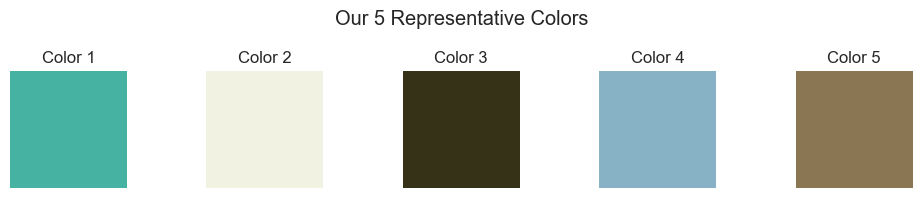

In [33]:
# Visualize our 5 representative colors
plt.figure(figsize=(10, 2))
for i, center in enumerate(centers):
    plt.subplot(1, 5, i+1)
    plt.imshow([[center]])
    plt.axis('off')
    plt.title(f'Color {i+1}')
plt.suptitle('Our 5 Representative Colors')
plt.tight_layout()
plt.show()

In [34]:
# Show distribution of pixels across clusters
pixel_counts = np.bincount(labels)
print("\nDistribution of pixels across clusters:")
for i, count in enumerate(pixel_counts):
    percentage = (count / len(labels)) * 100
    print(f"Color {i+1}: {count:,} pixels ({percentage:.1f}%)")


Distribution of pixels across clusters:
Color 1: 12,619 pixels (18.4%)
Color 2: 13,506 pixels (19.7%)
Color 3: 6,848 pixels (10.0%)
Color 4: 29,831 pixels (43.6%)
Color 5: 5,676 pixels (8.3%)


## Reconstructing the Compressed Image
 
Now we'll reconstruct our image using only the cluster centers (our reduced color palette). Each pixel gets assigned the color of its cluster's centroid.

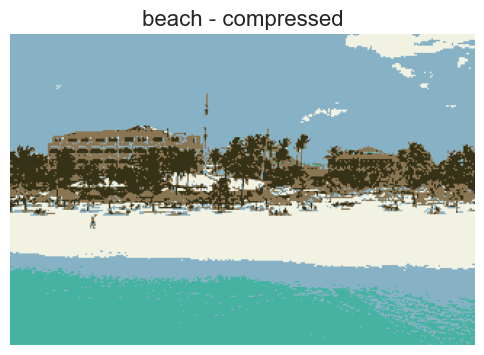

In [35]:
Ic = centers[labels].reshape(I.shape)
Ic.shape

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(Ic)
ax.set_title('beach - compressed', fontsize=16)
ax.axis('off')
plt.show()

## Understanding the Results

If you store these images as .bmp files, the original and compressed BMP files have similar sizes. This occurs because BMP files store pixel data directly, regardless of color redundancy. However, the true compression benefit becomes apparent when we examine the zipped versions of these files.
 
The compressed image, with its reduced color palette, contains far more redundant data than the original. This redundancy makes the file much more compressible by standard compression algorithms. In typical testing, compressing with K=5 might show these characteristics:
 
Raw files:
 - Original: ~920KB
 - Compressed: ~920KB
 
Zipped files:
 - Original: ~815KB
 - Compressed: ~246KB
 
## Quality and Performance Considerations
 
The relationship between compression level (K value) and image quality isn't linear:
 - At low K values (around 5): Distinct color bands and noticeable posterization
 - As K increases: Visual quality improves rapidly at first, then more gradually
 - Diminishing returns typically occur beyond K=32
 
Performance scales with:
 - Image size (number of pixels)
 - K value (number of clusters)
 - Number of iterations until convergence
 
 For a typical 1024x768 image:
 - K=5: ~2 seconds processing time
 - K=32: ~8 seconds processing time
 - Memory usage: 3-4x original image size